In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

import numpy as np
from pyannote.core import SlidingWindow, SlidingWindowFeature, Annotation, Timeline, Segment

from diart.models import EmbeddingModel, SegmentationModel
from diart import SpeakerDiarization, SpeakerDiarizationConfig

from utils import load_audio

hf_token = os.environ.get("HF_TOKEN")

segmentation = SegmentationModel.from_pretrained("pyannote/segmentation-3.0", use_hf_token=hf_token)
embedding = EmbeddingModel.from_pretrained("nvidia/speakerverification_en_titanet_large", use_hf_token=hf_token)

config = SpeakerDiarizationConfig(
    segmentation=segmentation,
    embedding=embedding
)
pipeline = SpeakerDiarization(config)

/home/raid/miniconda3/envs/nemo/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
INFO:datasets:PyTorch version 2.6.0+cu126 available.
[NeMo W 2025-03-03 11:38:29 nemo_logging:361] /home/raid/miniconda3/envs/nemo/lib/python3.10/site-packages/diart/audio.py:8: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
      torchaudio.set_audio_backend("soundfile")
    
[NeMo W 2025-03-03 11:38:31 modelPT:176] If you intend to do training or fine-tuning, please call the Mod

[NeMo I 2025-03-03 11:38:31 features:305] PADDING: 16
[NeMo I 2025-03-03 11:38:31 save_restore_connector:275] Model EncDecSpeakerLabelModel was successfully restored from /home/raid/.cache/huggingface/hub/models--nvidia--speakerverification_en_titanet_large/snapshots/0dc382f40121a5fbd34db10a2bb04d826c2be6a8/speakerverification_en_titanet_large.nemo.


  0%|          | 0/500 [00:00<?, ?it/s]

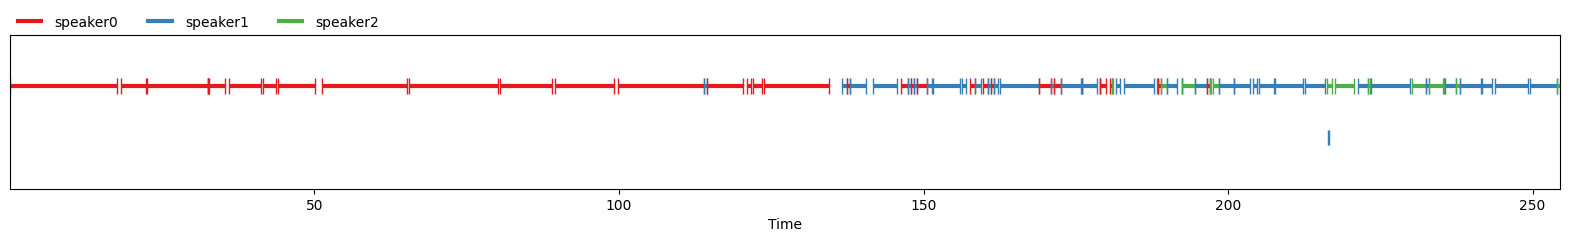

In [7]:
# Create an empty annotation to store the combined results
merged_annotation = Annotation()

for i in tqdm(range(500)):
    duration = int(pipeline.config.duration * pipeline.config.sample_rate)
    step = int(pipeline.config.step * pipeline.config.sample_rate)
    
    audio = waveform[0, step*i:duration+step*i].unsqueeze(-1).numpy()
    
    # Obtain and format audio
    sample_rate = pipeline.config.sample_rate
    sliding_window = SlidingWindow(
        start=i * pipeline.config.step,
        duration=1.0 / sample_rate,
        step=1.0 / sample_rate,
    )
    audio = SlidingWindowFeature(audio, sliding_window)
    
    # Get annotation for this chunk
    annotation, audio_chunk = pipeline([audio])[0]

    merged_annotation.update(annotation)

    # print('updated')
    # print(merged_annotation)
    
    # For the first chunk, simply use the full annotation
    # if i == 0:
    #     merged_annotation = annotation.copy()
    # else:
    #     for segment, track, label in annotation.itertracks(yield_label=True):
    #         print(segment)
    #         print(track)
    #         print(label)
        # For subsequent chunks, only consider the new part
        # Calculate the segment representing the new portion
        # new_segment_start = i * pipeline.config.step
        # new_segment_end = new_segment_start + pipeline.config.step
        # new_segment = Segment(new_segment_start, new_segment_end)

        # print(new_segment)
        
        # # Extract annotations from the current chunk that fall within the new segment
        # for segment, track, label in annotation.itertracks(yield_label=True):
        #     # Check if this segment overlaps with our "new" section
        #     segment_overlap = segment & new_segment
        #     merged_annotation[segment_overlap, track] = label

merged_annotation.support(0.05)

In [1]:
from faster_whisper import WhisperModel

/home/raid/miniconda3/envs/diart/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WhisperModel(
        "aether-raid/WLV3t-SG-LN-NoAugs-ct2", 
        device="cuda", 
        compute_type="float16",
        local_files_only=False,
    )

An error occured while synchronizing the model aether-raid/WLV3t-SG-LN-NoAugs-ct2 from the Hugging Face Hub:
401 Client Error. (Request ID: Root=1-67ca9b47-5f288703062898e207566614;d705dc95-4d80-4ccc-be1c-53224b695532)

Cannot access gated repo for url https://huggingface.co/aether-raid/WLV3t-SG-LN-NoAugs-ct2/resolve/3eed9cc81b5fb5e5c7650c18e20afc2a5394029c/config.json.
Access to model aether-raid/WLV3t-SG-LN-NoAugs-ct2 is restricted. You must have access to it and be authenticated to access it. Please log in.
Trying to load the model directly from the local cache, if it exists.


LocalEntryNotFoundError: Cannot find an appropriate cached snapshot folder for the specified revision on the local disk and outgoing traffic has been disabled. To enable repo look-ups and downloads online, pass 'local_files_only=False' as input.